In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import generative as gen
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform
import utils as ut
import seaborn as sns
from vizman import viz
from scipy import io
import pandas as pd
from brainspace.utils import parcellation
from neuromaps.datasets import fetch_fslr
from surfplot import Plot
from netneurotools.networks import struct_consensus


/Users/kf02/Library/Mobile Documents/com~apple~CloudDocs/Work/Optimal_networks/.venv/lib/python3.11/site-packages/tqdm_joblib/__init__.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
viz.set_visual_style()
viz_sizes = viz.load_data_from_json("sizes.json")
viz_colors = viz.load_data_from_json("colors.json")
viz_cmaps = viz.give_colormaps()
sns_kwargs = {"cmap": viz_cmaps["bw_lr"],
              "xticklabels":False,
              "yticklabels":False,
              "rasterized":True}

surfcolors = sns.blend_palette([
                                viz_colors["neutrals"]["ALL_WHITE"],
                                viz_colors["warms"]["LECKER_RED"]],
                                     as_cmap=True)

In [4]:
data = io.loadmat(
    "datasets/human/lifespan/lifespan_project_data.mat",
    simplify_cells=True,
    squeeze_me=True,
    chars_as_strings=True,
)

In [5]:
data["lifespan_project_data"]["sample"]["info"]

array(['Sex: male = 0, female = 1',
       'Study_ids contains ids for each study - for BCP this includes the session and scan type',
       'Subject_ids are numbers that are unique to each unique subject and repeat for index that contain the same subject but different scan (either session or scan type)',
       'Atlas: neonatal = 1; 1-year-old = 2, 2-year-old = 3; adult = 4',
       'Study: dHCP = 1, BCP = 2 , CALM = 3, RED = 4, ACE = 5, HCPd = 6, HCPya = 7, camCAN = 8, HCPa = 9',
       'Neurogroup: neurotypical = 1, neurodiverse = 2'], dtype=object)

In [6]:
data["lifespan_project_data"]["sample"].keys()

dict_keys(['info', 'study_ids', 'subject_ids', 'ages', 'sex', 'atlas', 'studies', 'neurogroup'])

In [7]:
test = data["lifespan_project_data"]["connectomes"]["unthresholded"][1,:,:]
nx.is_connected(nx.from_numpy_array(test))

False

In [8]:
#connectomes = data["lifespan_project_data"]["connectomes"]["controlled_density"]["binarised"]
connectomes = data["lifespan_project_data"]["connectomes"]["variable_density"]["binarised"]


In [9]:
weighted_connectomes = data["lifespan_project_data"]["connectomes"]["variable_density"]["normalised_weighted"]

In [10]:
atlas = io.loadmat(
    "datasets/human/lifespan/aal90.mat",
    simplify_cells=True,
    squeeze_me=True,
    chars_as_strings=True,
)

In [11]:
labels = atlas["aal90"]["region_labels"]
coordinates = atlas["aal90"]["coor_adult"]
euclidean_distances = squareform(pdist(coordinates))

lh_vertex_labels = np.load("./datasets/human/lifespan/AAL90_lh_labels.npy")
rh_vertex_labels = np.load("./datasets/human/lifespan/AAL90_rh_labels.npy")

In [12]:
info = pd.DataFrame({"sex": data["lifespan_project_data"]["sample"]["sex"],
                     "subject_ids": data["lifespan_project_data"]["sample"]["subject_ids"],
                     "atlas": data["lifespan_project_data"]["sample"]["atlas"],
                     "ages": data["lifespan_project_data"]["sample"]["ages"],
                     "studies": data["lifespan_project_data"]["sample"]["studies"],
                     "neurogroup": data["lifespan_project_data"]["sample"]["neurogroup"],})

In [13]:
hcp_ya = connectomes[info["studies"] == 7].transpose(1, 2, 0)
hcp_ya.shape

(90, 90, 1062)

In [14]:
(connectomes[info["studies"] == 7][0,:,:] == hcp_ya[:,:,0]).all()

True

In [15]:
connectedness = []
for i in range(hcp_ya.shape[2]):
    G = nx.from_numpy_array(hcp_ya[:,:,i])
    connectedness.append(nx.is_connected(G))
np.sum(connectedness)

373

In [16]:
hcp_ya = hcp_ya[:,:,connectedness]
hcp_ya.shape

(90, 90, 373)

In [17]:
empirical_densities = np.array([ut.check_density(hcp_ya[:,:,i]) for i in range(hcp_ya.shape[2])])

In [18]:
hemiid = np.zeros(90)
hemiid[::2] = 1  # Set every even index to 1

In [32]:
weighted_hcp_ya = weighted_connectomes[info["studies"] == 7].transpose(1, 2, 0)
empirical_consensus = struct_consensus(weighted_hcp_ya, 
                                       distance=euclidean_distances,
                                       hemiid=hemiid.reshape(-1, 1))

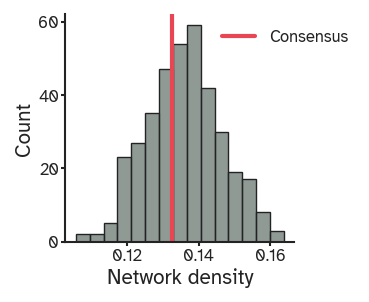

In [20]:
plt.figure(figsize=viz.cm_to_inch((5,5)), dpi=150)
sns.histplot(empirical_densities)
plt.axvline(ut.check_density(empirical_consensus),
            lw=2,color=viz_colors["warms"]["LECKER_RED"],label="Consensus")
plt.xlabel("Network density")
plt.legend(bbox_to_anchor=(1.3,1),frameon=False)
sns.despine()
#plt.savefig("figures/res1_allconns_density_histplot.pdf",dpi=600,bbox_inches='tight');

In [33]:
nx.is_connected(nx.from_numpy_array(empirical_consensus))

False

In [34]:
# Get the connected components
components = list(nx.connected_components(nx.from_numpy_array(empirical_consensus)))

if len(components) > 1:
    node_from = min(components[0])  # node from first component
    node_to = min(components[1])    # node from second component    
    # Add edge between components
    empirical_consensus[node_from, node_to] = 1
    empirical_consensus[node_to, node_from] = 1  # Since it's undirected


In [35]:
nx.is_connected(nx.from_numpy_array(empirical_consensus))

True

In [36]:
ut.check_density(empirical_consensus)

0.13283395755305868

In [37]:
empirical_densities.mean()

0.13588911983345214

In [38]:
n_iterations = 3_000
n_nodes = labels.shape[0]
beta = np.full(n_iterations, 1)
noise = np.zeros(n_iterations)
penalty = np.zeros(n_iterations)
batch_size = np.full(n_iterations, 8)

start = 1
stop = 3
params = np.linspace(start, stop, 31)
scores = np.zeros(len(params))
histories = np.zeros((n_nodes, n_nodes, n_iterations, len(params)))
densities = np.zeros(len(params))
for ind, val in enumerate(params):
    alpha = np.full(n_iterations, val)
    histories[...,ind] = gen.simulate_network_evolution(
        coordinates=coordinates,
        n_iterations=n_iterations,
        alpha=alpha,
        beta=np.full(n_iterations, 1),
        noise=noise,
        distance_fn=gen.resistance_distance,
        connectivity_penalty=penalty,
        n_jobs=-1,
        random_seed=11,
        batch_size=batch_size,
    )
    scores[ind] = ut.density_distance(histories[:,:,-1,ind],
                                      empirical_consensus, 
                                      absolute=False)
    densities[ind] = ut.check_density(histories[:,:,-1,ind])
    print(f"Parameter {val} error: {scores[ind]:.4f}")
np.save("simulations/diffusion_HCPya_3k_scores.npy",scores)
np.save("simulations/diffusion_HCPya_3k_matrices.npy",histories)
np.save("simulations/diffusion_HCPya_3k_densities.npy",densities)

Simulating network evolution: 100%|██████████| 2999/2999 [00:53<00:00, 55.55it/s]


Parameter 1.0 error: -0.0425


Simulating network evolution: 100%|██████████| 2999/2999 [00:36<00:00, 81.40it/s]


Parameter 1.0666666666666667 error: -0.0393


Simulating network evolution: 100%|██████████| 2999/2999 [00:37<00:00, 80.53it/s]


Parameter 1.1333333333333333 error: -0.0341


Simulating network evolution: 100%|██████████| 2999/2999 [00:36<00:00, 81.67it/s]


Parameter 1.2 error: -0.0336


Simulating network evolution: 100%|██████████| 2999/2999 [00:37<00:00, 81.02it/s]


Parameter 1.2666666666666666 error: -0.0291


Simulating network evolution: 100%|██████████| 2999/2999 [00:36<00:00, 81.30it/s]


Parameter 1.3333333333333333 error: -0.0286


Simulating network evolution: 100%|██████████| 2999/2999 [00:36<00:00, 81.31it/s]


Parameter 1.4 error: -0.0259


Simulating network evolution: 100%|██████████| 2999/2999 [00:37<00:00, 79.29it/s]


Parameter 1.4666666666666668 error: -0.0262


Simulating network evolution: 100%|██████████| 2999/2999 [00:40<00:00, 73.54it/s]


Parameter 1.5333333333333332 error: -0.0240


Simulating network evolution: 100%|██████████| 2999/2999 [00:40<00:00, 73.46it/s]


Parameter 1.6 error: -0.0215


Simulating network evolution: 100%|██████████| 2999/2999 [00:40<00:00, 73.76it/s]


Parameter 1.6666666666666665 error: -0.0183


Simulating network evolution: 100%|██████████| 2999/2999 [00:40<00:00, 73.40it/s]


Parameter 1.7333333333333334 error: -0.0165


Simulating network evolution: 100%|██████████| 2999/2999 [00:41<00:00, 73.04it/s]


Parameter 1.8 error: -0.0151


Simulating network evolution: 100%|██████████| 2999/2999 [00:40<00:00, 73.33it/s]


Parameter 1.8666666666666667 error: -0.0143


Simulating network evolution: 100%|██████████| 2999/2999 [00:38<00:00, 78.20it/s]


Parameter 1.9333333333333333 error: -0.0111


Simulating network evolution: 100%|██████████| 2999/2999 [00:36<00:00, 81.57it/s]


Parameter 2.0 error: -0.0099


Simulating network evolution: 100%|██████████| 2999/2999 [00:37<00:00, 80.40it/s]


Parameter 2.0666666666666664 error: -0.0079


Simulating network evolution: 100%|██████████| 2999/2999 [00:36<00:00, 81.46it/s]


Parameter 2.1333333333333333 error: -0.0052


Simulating network evolution: 100%|██████████| 2999/2999 [00:36<00:00, 81.59it/s]


Parameter 2.2 error: -0.0032


Simulating network evolution: 100%|██████████| 2999/2999 [00:36<00:00, 81.86it/s]


Parameter 2.2666666666666666 error: -0.0027


Simulating network evolution: 100%|██████████| 2999/2999 [00:36<00:00, 81.16it/s]


Parameter 2.333333333333333 error: -0.0010


Simulating network evolution: 100%|██████████| 2999/2999 [00:37<00:00, 79.82it/s]


Parameter 2.4 error: 0.0010


Simulating network evolution: 100%|██████████| 2999/2999 [00:36<00:00, 81.19it/s]


Parameter 2.466666666666667 error: 0.0010


Simulating network evolution: 100%|██████████| 2999/2999 [00:36<00:00, 81.25it/s]


Parameter 2.533333333333333 error: 0.0032


Simulating network evolution: 100%|██████████| 2999/2999 [00:37<00:00, 81.05it/s]


Parameter 2.6 error: 0.0067


Simulating network evolution: 100%|██████████| 2999/2999 [00:37<00:00, 80.91it/s]


Parameter 2.666666666666667 error: 0.0084


Simulating network evolution: 100%|██████████| 2999/2999 [00:37<00:00, 80.35it/s]


Parameter 2.7333333333333334 error: 0.0067


Simulating network evolution: 100%|██████████| 2999/2999 [00:36<00:00, 81.41it/s]


Parameter 2.8 error: 0.0101


Simulating network evolution: 100%|██████████| 2999/2999 [00:36<00:00, 81.34it/s]


Parameter 2.8666666666666667 error: 0.0123


Simulating network evolution: 100%|██████████| 2999/2999 [00:36<00:00, 81.14it/s]


Parameter 2.9333333333333336 error: 0.0138


Simulating network evolution: 100%|██████████| 2999/2999 [00:37<00:00, 81.03it/s]


Parameter 3.0 error: 0.0143


In [105]:
densities = np.load("simulations/diffusion_HCPya_3k_densities.npy")
scores = np.load("simulations/diffusion_HCPya_3k_scores.npy")
histories = np.load("simulations/diffusion_HCPya_3k_matrices.npy")

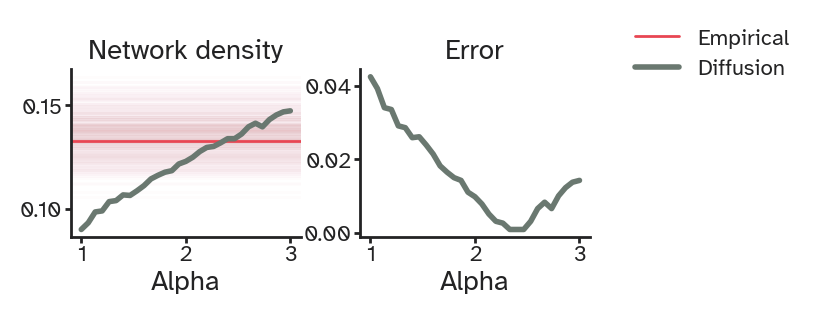

In [45]:

fig, axes = plt.subplot_mosaic([["A", "B"]], 
                               figsize=(viz.cm_to_inch((8,4))),
                               dpi=200,sharex=True)
for subject in range(hcp_ya.shape[2]):
    axes["A"].axhline(empirical_densities[subject],color=viz_colors["warms"]["LECKER_RED"],alpha=0.01)
axes["A"].axhline(ut.check_density(empirical_consensus),
                  color=viz_colors["warms"]["LECKER_RED"],label="Empirical")
axes["A"].plot(params,densities,lw=2,label="Diffusion")


axes["B"].plot(params,np.abs(scores),lw=2)

axes["A"].set_title("Network density")
axes["B"].set_title("Error")
axes["A"].set_xlabel("Alpha")
axes["B"].set_xlabel("Alpha")
fig.legend(bbox_to_anchor=(1.3,1),frameon=False)
fig.tight_layout(w_pad=0.1)
sns.despine()
plt.savefig("figures/HCP/densities_errors.pdf",dpi=600,bbox_inches='tight');

In [ ]:
rng = np.random.default_rng(11)
n_iterations = 5000
n_subjects = hcp_ya.shape[2]
simulated_networks = np.zeros((n_nodes, n_nodes, n_iterations,n_subjects))
alphas = rng.normal(params[np.argmin(np.abs(scores))],0.2,n_subjects)

for subject in range(n_subjects):
    print(f"Subject {subject+1}/{n_subjects}")
    simulated_networks[...,subject] = gen.simulate_network_evolution(
        coordinates=coordinates,
        n_iterations=n_iterations,
        alpha=np.full(n_iterations, alphas[subject]),
        beta=np.full(n_iterations, 1),
        noise=np.zeros(n_iterations),
        distance_fn=gen.resistance_distance,
        connectivity_penalty=np.zeros(n_iterations),
        n_jobs=-1,
        random_seed=11,
        batch_size=np.full(n_iterations, 9),
    )
    
np.save("simulations/diffusion_HCPya_5k_samples.npy",simulated_networks)
simulated_networks = np.load("simulations/diffusion_HCPya_5k_samples.npy")

In [62]:
simulated_networks.shape

(90, 90, 5000, 373)

Text(0.5, 1.0, 'One HCP subject')

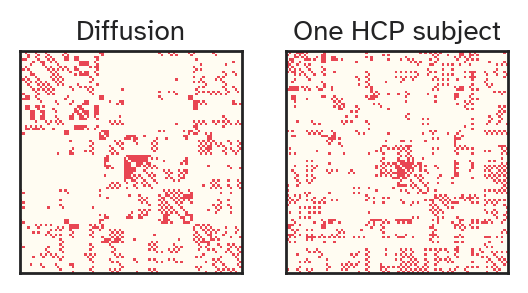

In [64]:
fig, axes = plt.subplot_mosaic([["A", "B"]], 
                               figsize=(viz.cm_to_inch((8,4))),
                               dpi=200)
viz.plot_matrix(simulated_networks[:,:,-1,15],
                cbar=False,sns_kwargs=sns_kwargs,axis=axes["A"])
viz.plot_matrix(hcp_ya[:,:,15], 
                cbar=False, sns_kwargs=sns_kwargs, axis=axes["B"])
axes["A"].set_title("Diffusion")
axes["B"].set_title("One HCP subject")
#plt.savefig("figures/HCP/example_adjmats.pdf",dpi=600,bbox_inches='tight');

In [91]:
empirical_similarity = np.zeros((hcp_ya.shape[0],hcp_ya.shape[-1]))
simulated_similarity = np.zeros((hcp_ya.shape[0],hcp_ya.shape[-1]))
network_distance = np.zeros_like((hcp_ya),dtype=float)
for subject in range(hcp_ya.shape[-1]):
    empirical_similarity[:,subject] = ut.calculate_endpoint_similarity(hcp_ya[:,:,subject],
                                                                       empirical_consensus)
    simulated_similarity[:,subject] = ut.calculate_endpoint_similarity(simulated_networks[:,:,-1,subject],
                                                                       empirical_consensus)
    network_distance[:,:,subject] = hcp_ya[:,:,subject]-simulated_networks[:,:,-1,subject]
    
empirical_similarity = pd.DataFrame(empirical_similarity.T,columns=labels)
simulated_similarity = pd.DataFrame(simulated_similarity.T,columns=labels)
averaged_network_distance = np.mean(network_distance,axis=-1)
averaged_network_distance = pd.DataFrame(averaged_network_distance,columns=labels)

In [93]:
averaged_network_distance

,Precentral_L,Precentral_R,Frontal_Sup_L,Frontal_Sup_R,Frontal_Sup_Orb_L,Frontal_Sup_Orb_R,Frontal_Mid_L,Frontal_Mid_R,Frontal_Mid_Orb_L,Frontal_Mid_Orb_R,...,Temporal_Sup_L,Temporal_Sup_R,Temporal_Pole_Sup_L,Temporal_Pole_Sup_R,Temporal_Mid_L,Temporal_Mid_R,Temporal_Pole_Mid_L,Temporal_Pole_Mid_R,Temporal_Inf_L,Temporal_Inf_R
0,0.000000,0.619303,-0.155496,0.581769,0.831099,0.509383,-0.142091,0.080429,0.646113,0.008043,...,0.048257,0.000000,0.064343,0.002681,0.605898,0.000000,0.029491,0.000000,0.635389,0.002681
1,0.619303,0.000000,0.203753,-0.249330,0.067024,0.820375,0.056300,-0.032172,0.021448,0.514745,...,0.002681,-0.048257,0.005362,0.075067,0.000000,0.348525,0.000000,0.010724,0.002681,0.332440
2,-0.155496,0.203753,0.000000,-0.040214,0.927614,0.694370,-0.034853,0.300268,0.817694,0.324397,...,0.088472,0.000000,0.461126,0.013405,0.144772,0.000000,0.225201,0.000000,0.166220,0.024129
3,0.581769,-0.249330,-0.040214,0.000000,0.667560,0.954424,0.117962,-0.050938,0.276139,0.806971,...,0.002681,0.069705,0.018767,0.332440,0.005362,0.152815,0.005362,0.230563,0.002681,0.190349
4,0.831099,0.067024,0.927614,0.667560,0.000000,0.010724,0.608579,0.268097,-0.155496,0.327078,...,0.018767,0.000000,-0.402145,0.008043,0.372654,0.000000,-0.356568,0.016086,0.501340,0.016086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.000000,0.348525,0.000000,0.152815,0.000000,0.517426,0.000000,0.394102,0.002681,0.391421,...,0.000000,-0.010724,0.002681,0.469169,0.010724,0.000000,0.008043,0.670241,0.021448,-0.008043
86,0.029491,0.000000,0.225201,0.005362,-0.356568,0.002681,0.024129,0.000000,-0.643432,0.000000,...,0.144772,0.000000,-0.680965,0.005362,0.619303,0.008043,0.000000,0.187668,-0.445040,0.077748
87,0.000000,0.010724,0.000000,0.230563,0.016086,-0.176944,0.000000,0.008043,0.000000,-0.863271,...,0.000000,0.402145,0.032172,-0.801609,0.080429,0.670241,0.187668,0.000000,0.206434,-0.383378
88,0.635389,0.002681,0.166220,0.002681,0.501340,0.002681,0.608579,0.002681,0.592493,0.000000,...,-0.635389,0.002681,-0.364611,0.002681,-0.008043,0.021448,-0.445040,0.206434,0.000000,0.206434


In [160]:
from netneurotools.modularity import consensus_modularity

test = consensus_modularity(averaged_network_distance.values,
                            B="negative_sym",repeats=500)

In [151]:
averaged_network_distance.index = averaged_network_distance.columns

In [ ]:
averaged_network_distance

In [161]:
# Create a DataFrame with labels and their community assignments
community_df = pd.DataFrame({
    'label': averaged_network_distance.columns,
    'community': test[0]  # e.g., test[0] if that's your community assignment array
}).sort_values('community')

# Reorder the matrix based on the sorted community labels
reordered_matrix = averaged_network_distance.loc[community_df['label'], community_df['label']]

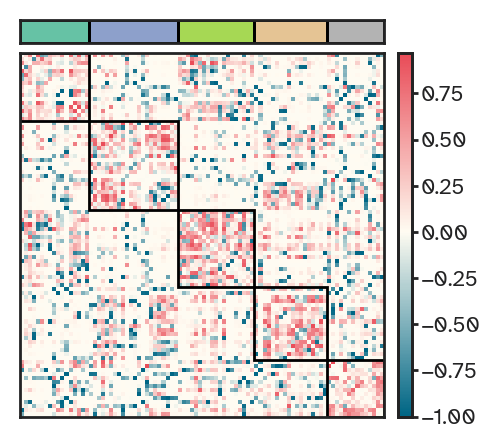

In [179]:
plt.figure(figsize=(viz.cm_to_inch((6,6))),dpi=200)
ax = plt.gca()
viz.plot_matrix(reordered_matrix,
                community_labels=sorted(list(test[0])),
                community_cmap="Set2",
                cbar=True,axis=ax,
                sns_kwargs={"cmap":viz_cmaps["db_bw_lr"],
                            "xticklabels":False,
                            "yticklabels":False,"rasterized":True})
fig.savefig("figures/HCP/consensus_modularity_matrix.pdf",dpi=600,bbox_inches='tight')

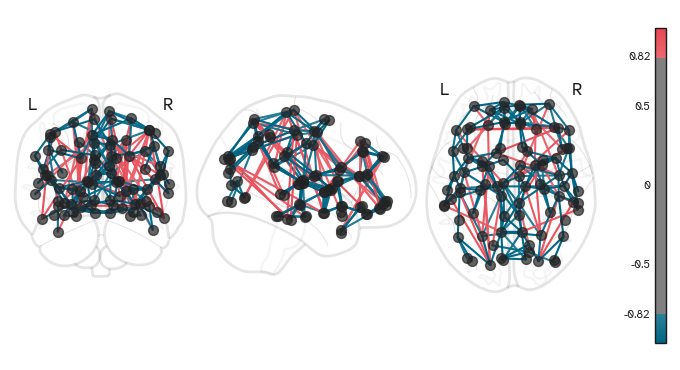

In [165]:
from nilearn.plotting import plot_connectome

plot_connectome(averaged_network_distance,
                coordinates,
                node_color=viz_colors["neutrals"]["HALF_BLACK"],
                edge_cmap=viz_cmaps["db_bw_lr"],
                edge_threshold="95%",
                alpha=0.1,
                colorbar=True,
                edge_kwargs={"linewidth":1.5},
                node_kwargs={"alpha":0.7})
#plt.savefig("figures/HCP/network difference.pdf",dpi=600,bbox_inches='tight');

In [166]:
# left_data = simulated_similarity.iloc[:,::2].copy()
# right_data = simulated_similarity.iloc[:,1::2].copy()
# left_surfdata = parcellation.map_to_labels(left_data.mean(1),lh_vertex_labels)
# right_surfdata = parcellation.map_to_labels(right_data.mean(1),rh_vertex_labels)

# left_data = averaged_network_distance.mean(0).iloc[::2].copy()
# right_data = averaged_network_distance.mean(0).iloc[1::2].copy()

left_data = test[0][::2].copy()
right_data = test[0][1::2].copy()
left_surfdata = parcellation.map_to_labels(left_data,lh_vertex_labels)
right_surfdata = parcellation.map_to_labels(right_data,rh_vertex_labels)

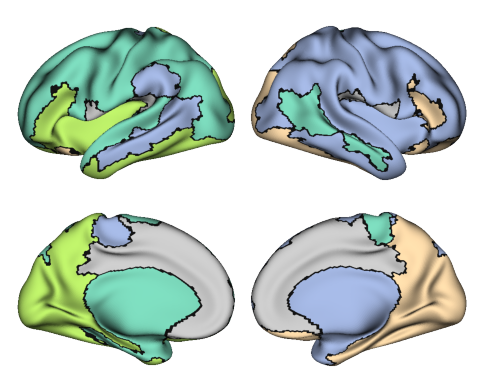

In [172]:
surfaces = fetch_fslr()
lh, rh = surfaces['inflated']


p = Plot(surf_lh=lh, surf_rh=rh,
         brightness=0.8)
p.add_layer({'left':left_surfdata, 
             'right':right_surfdata}, 
            cmap="Set2",cbar=False)

p.add_layer({'left':left_surfdata, 
             'right':right_surfdata}, 
            cmap='binary_r',
            as_outline=True,
            cbar=False)
fig = p.build()
fig.savefig("figures/HCP/communities_difference.pdf", dpi=600, bbox_inches="tight")

In [180]:
simulated_networks.shape

(90, 90, 5000, 373)

In [181]:
diffusion_measures = ut.compute_graph_metrics_parallel(simulated_networks[:,:,-1,:],
                                                    empirical_consensus,
                                                    euclidean_distances,
                                                    coordinates)
diffusion_measures.to_csv("results/HCP/diffusion_measures_373.csv",index=False)
diffusion_measures = pd.read_csv("results/HCP/diffusion_measures_373.csv")

100%|██████████| 373/373 [02:59<00:00,  2.07it/s]00:00<?, ?it/s]


In [182]:
empirical_measures = ut.compute_graph_metrics_parallel(hcp_ya,
                                                    empirical_consensus,
                                                    euclidean_distances,
                                                    coordinates)
empirical_measures.to_csv("results/HCP/empirical_measures_373.csv",index=False)
empirical_measures = pd.read_csv("results/HCP/empirical_measures_373.csv")






























































































































































































































































































































100%|██████████| 373/373 [03:35<00:00,  1.73it/s]


In [183]:
from bct import randmio_und, latmio_und

In [184]:
randomized_networks = np.zeros_like(hcp_ya)
latticized_networks = np.zeros_like(hcp_ya)

for subject in tqdm(range(hcp_ya.shape[2])):
    # randmio_und returns a tuple (randomized_matrix, num_swaps)
    # we only want the randomized matrix
    randomized_networks[:,:,subject] = randmio_und(hcp_ya[:,:,subject],
                                                   itr=32, seed=subject)[0]
    # latmio_und returns a tuple (latticized_matrix, num_swaps)
    # we only want the latticized matrix
    latticized_networks[:,:,subject] = latmio_und(hcp_ya[:,:,subject],
                                                  itr=32, seed=subject)[0]

np.save("results/HCP/randomized_networks_373.npy",randomized_networks)
np.save("results/HCP/latticized_networks_373.npy",latticized_networks)

randomized_networks = np.load("results/HCP/randomized_networks_373.npy")
latticized_networks = np.load("results/HCP/latticized_networks_373.npy")























































































































































































































































































































































































100%|██████████| 373/373 [04:03<00:00,  1.53it/s]


In [185]:
randomized_measures = ut.compute_graph_metrics_parallel(randomized_networks,
                                                     empirical_consensus,
                                                     euclidean_distances,
                                                     coordinates)
latticized_measures = ut.compute_graph_metrics_parallel(latticized_networks,
                                                     empirical_consensus,
                                                     euclidean_distances,
                                                     coordinates)
randomized_measures.to_csv("results/HCP/randomized_measures_373.csv",index=False)
latticized_measures.to_csv("results/HCP/latticized_measures_373.csv",index=False)

randomized_measures = pd.read_csv("results/HCP/randomized_measures_373.csv")
latticized_measures = pd.read_csv("results/HCP/latticized_measures_373.csv")
































































































































































































































































































































































































































































































































































































































































100%|██████████| 373/373 [03:37<00:00,  1.71it/s]








Computing graph metrics:   0%|          | 0/373 [03:44<?, ?it/s]
















































































































































































































































In [186]:
measure_labels = ["diffusion distance",
                    "shortest path distance",
                    "propagation distance",
                    "topological distance",
                    "density",
                    "wiring cost",
                    "average clustering",
                    "degree assortativity",
                    "small-worldness",
                    "endpoint similarity",
                    "accuracy",
                    "F1 score"]

consensus_measures = np.zeros(len(measure_labels))
consensus_measures[0] = gen.resistance_distance(empirical_consensus,coordinates).mean()
consensus_measures[1] = gen.shortest_path_distance(empirical_consensus,coordinates).mean()
consensus_measures[2] = gen.propagation_distance(empirical_consensus,coordinates).mean()
consensus_measures[3] = gen.topological_distance(empirical_consensus,coordinates).mean()

consensus_measures[4] = ut.check_density(empirical_consensus)
consensus_measures[5] = ut.calculate_wiring_cost(empirical_consensus,euclidean_distances)
G = nx.from_numpy_array(empirical_consensus)
consensus_measures[6] = nx.average_clustering(G)
consensus_measures[7] = nx.degree_assortativity_coefficient(G)
consensus_measures[8] = ut.compute_omega(empirical_consensus)
consensus_measures = pd.DataFrame([consensus_measures], columns=measure_labels)
consensus_measures.to_csv("results/HCP/consensus_measures_373.csv",index=False)

consensus_measures = pd.read_csv("results/HCP/consensus_measures_373.csv")

In [187]:
diffusion_measures['model'] = 'Diffusion'
empirical_measures['model'] = 'Empirical'
latticized_measures['model'] = 'Latticized'
randomized_measures['model'] = 'Randomized'

all_measures = pd.concat([
    diffusion_measures,
    empirical_measures,
    latticized_measures,
    randomized_measures,
], axis=0).reset_index(drop=True)

all_measures['sample_id'] = all_measures.groupby('model').cumcount()

all_measures.replace([np.inf, -np.inf], np.nan, inplace=True)
all_measures.to_csv("results/HCP/all_measures_373.csv",index=False)

all_measures = pd.read_csv("results/HCP/all_measures_373.csv")

In [188]:
all_measures.head()

,diffusion distance,shortest path distance,propagation distance,topological distance,density,wiring cost,average clustering,degree assortativity,small-worldness,endpoint similarity,accuracy,F1 score,model,sample_id
0,6.676358,2.535556,1.558143,0.870143,0.129838,4.301013,0.441449,0.096644,0.143152,0.276820,81.185185,0.275665,Diffusion,0
1,6.157541,2.462716,1.548543,0.857953,0.141823,4.850391,0.457071,0.084519,0.129861,0.286993,80.592593,0.285455,Diffusion,1
2,6.312754,2.485679,1.574098,0.860550,0.138577,4.656953,0.465752,0.086566,0.110411,0.270581,80.419753,0.270469,Diffusion,2
3,6.746390,2.563210,1.598026,0.870624,0.129338,4.278711,0.443622,0.150502,0.125045,0.276178,81.234568,0.276190,Diffusion,3
4,6.699496,2.533086,1.562203,0.870752,0.129338,4.297121,0.438693,0.137363,0.149678,0.274019,81.135802,0.272381,Diffusion,4


In [189]:
colors = [viz_colors["neutrals"]["OLIVE_GRAY"], # diffusion
          viz_colors["warms"]["LECKER_RED"], # empirical
          viz_colors["neutrals"]["GRAY"], # latticized
          viz_colors["neutrals"]["GRAY"]] # randomized

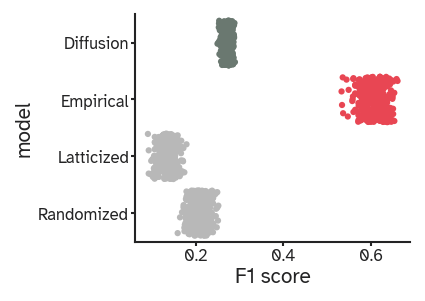

In [201]:
plt.figure(figsize=(viz.cm_to_inch((6,5))), dpi=150)
measure = "F1 score"
sns.stripplot(data=all_measures, 
              y="model",
              x=measure,
              hue="model",
              size=3,
              jitter=0.4,
              palette=colors)

empirical_values = all_measures[all_measures['model'] == 'Empirical'][measure]
plt.xlabel(measure.capitalize())

#plt.xlim(0.05,0.15)
sns.despine()
plt.savefig(f"figures/HCP/{measure}_stripplot_373.pdf",dpi=600,bbox_inches='tight');

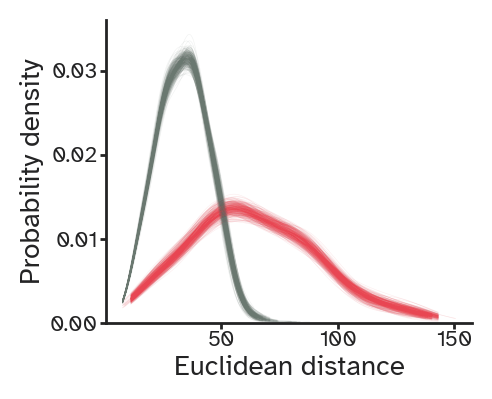

In [209]:
plt.figure(figsize=(viz.cm_to_inch((6,5))), dpi=200)
cumu = False

for subject in range(hcp_ya.shape[2]):
    sns.kdeplot(euclidean_distances[hcp_ya[:,:,subject].astype(bool)],
                lw=0.2,
                alpha=0.1,
                color=viz_colors["warms"]["LECKER_RED"],
                bw_adjust=1.5,cut=0,cumulative=cumu)
    sns.kdeplot(euclidean_distances[simulated_networks[:,:,-1,subject].astype(bool)],
                lw=0.2,
                alpha=0.1,
                bw_adjust=1.5,cut=0,
                color=viz_colors["neutrals"]["OLIVE_GRAY"],
                cumulative=cumu)


plt.xlabel('Euclidean distance')
plt.ylabel('Probability density')
sns.despine()
plt.savefig("figures/HCP/kdeplot_373.pdf",dpi=600,bbox_inches='tight');